In [1]:
import os,sys,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from itertools import product
#import pickle5 # Need pickle5 for DataFrame pickles
from scipy.stats import linregress,sem
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mue
import seaborn as sns
from natsort import natsorted as ns
from natsort import *
import matplotlib as mpl
import multiprocessing as mp
cpus = mp.cpu_count()
from sklearn.metrics import confusion_matrix,matthews_corrcoef


In [2]:
A8 = pd.read_pickle('../../data/EE/A8_RBFE.pkl')
A13 = pd.read_pickle('../../data/EE/A13_RBFE.pkl').fillna(0)
A18 = pd.read_pickle('../../data/EE/A18_RBFE.pkl')
A8_var = pd.read_pickle('../../data/EE/A8_variance.pkl')
A13_var = pd.read_pickle('../../data/EE/A13_variance.pkl').fillna(0)
A18_var = pd.read_pickle('../../data/EE/A18_variance.pkl')
on = False
if on:
    for col in A8.columns:
        A8[col] = np.mean(A8[col].values+np.random.randn(100000,len(A8[col]))*A8_var[col].values,axis=0)
    for col in A18.columns:
        A18[col] = np.mean(A18[col].values+np.random.randn(100000,len(A18[col]))*A18_var[col].values,axis=0)
    for col in A13.columns:
        A13[col] = np.mean(A13[col].values+np.random.randn(100000,len(A13[col]))*A13_var[col].values,axis=0)

A8_old = pd.read_pickle('../../data/old_EE/A8_RBFE.pkl').fillna(0)
A13_old = pd.read_pickle('../../data/old_EE/A13_RBFE.pkl').fillna(0)
A18_old = pd.read_pickle('../../data/old_EE/A18_RBFE.pkl').fillna(0)
old_A8_var = pd.read_pickle('../../data/old_EE/A8_variance.pkl').fillna(0)
old_A13_var = pd.read_pickle('../../data/old_EE/A13_variance.pkl').fillna(0)
old_A18_var = pd.read_pickle('../../data/old_EE/A18_variance.pkl').fillna(0)

#A8_exp = pd.read_csv('A8_initial_Log10Kd_estimates_20230913.csv')
A8_exp = pd.read_pickle('../../data/Experiment/A8_exp_dg.pkl').reindex(A8.index).fillna(0)
A8_exp_unc = pd.read_pickle('../../data/Experiment/A8_exp_unc.pkl').reindex(A8.index).fillna(0)
A8_seq = open('../../data/sequences/A8_sequence.afasta').readlines()[0].replace('\n','')
#A8_exp=transform_exp(A8_exp,A8_seq)
A8_seq =[f'{A8_seq[i]}{270+i}' for i in range(len(A8_seq))]


#A18_exp = pd.read_csv('A18_initial_Log10Kd_estimates_20230913.csv')
A18_exp = pd.read_pickle('../../data/Experiment/A18_exp_dg.pkl').reindex(A18.index).fillna(0)
A18_exp_unc = pd.read_pickle('../../data/Experiment/A18_exp_unc.pkl').reindex(A18.index).fillna(0)
A18_seq = open('../../data/sequences/A18_sequence.afasta').readlines()[0].replace('\n','')
#A18_exp=transform_exp(A18_exp,A18_seq)
A18_seq=[f'{A18_seq[i]}{270+i}' for i in range(len(A18_seq))]


#A13_exp = pd.read_csv('A13_initial_Log10Kd_estimates_20230913.csv')
A13_exp = pd.read_pickle('../../data/Experiment/A13_exp_dg.pkl').reindex(A13.index).fillna(0)
A13_exp_unc = pd.read_pickle('../../data/Experiment/A13_exp_unc.pkl').reindex(A13.index).fillna(0)
A13_seq = open('../../data/sequences/A13_sequence.afasta').readlines()[0].replace('\n','')
#A13_exp=transform_exp(A13_exp,A13_seq)
A13_seq =[f'{A13_seq[i]}{270+i}' for i in range(len(A13_seq))]

# Fix Rosetta A8 Df
A8_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A8_rosetta.csv')
A8_ros_pub = A8_ros_pub.rename(columns={A8_ros_pub.columns[0]:''}) 
A8_ros_pub.set_index(A8_ros_pub.columns[0],inplace=True)

# Fix Rosetta A13 Df
A13_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A13_rosetta.csv')
A13_ros_pub = A13_ros_pub.rename(columns={A13_ros_pub.columns[0]:''}) 
A13_ros_pub.set_index(A13_ros_pub.columns[0],inplace=True)

# Fix Rosetta A18 Df
A18_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A18_rosetta.csv')
A18_ros_pub = A18_ros_pub.rename(columns={A18_ros_pub.columns[0]:''}) 
A18_ros_pub.set_index(A18_ros_pub.columns[0],inplace=True)

A8_ros_pub = A8_ros_pub * -1
A13_ros_pub = A13_ros_pub * -1
A18_ros_pub = A18_ros_pub * -1

A8_curr_ros = pd.read_csv('../../data/current_rosetta/A8_current_rosetta.csv')
A13_curr_ros = pd.read_csv('../../data/current_rosetta/A13_current_rosetta.csv')
A18_curr_ros = pd.read_csv('../../data/current_rosetta/A18_current_rosetta.csv')


def make_df(output,temp):
    output = output[output['state']=='ddg']
    index = list(temp.index)
    columns = temp.columns
    array = np.zeros(shape=(len(index),len(columns)))
    temp = pd.DataFrame(array,index=index,columns=columns)
    for index,row in output.iterrows():
        _col = row['position_label']
        _mut = row['mutation'][-1]
        _val = row['total_score']
        temp[_col][_mut]+=_val
    return temp

A8_curr_ros = make_df(A8_curr_ros,A8_ros_pub.copy())
A13_curr_ros = make_df(A13_curr_ros,A13_ros_pub.copy())
A18_curr_ros = make_df(A18_curr_ros,A18_ros_pub.copy())

In [3]:
def trinary_classifier(df,cutoff=1.2):
    classes = ['Destabilizing','Neutral','Stabilizing'] #'Neutral',
    columns = df.columns
    index = list(df.index)
    conditions = [df >= cutoff,(df > -cutoff) & (df < cutoff),df <= -cutoff]#(df > -cutoff) & (df < cutoff)
    df = np.select(conditions, classes)
    df = pd.DataFrame(df,columns=columns)
    df.index = index
    return df

def binary_classifier(df,cutoff=0.0):
    classes = ['Destabilizing','Stabilizing'] #'Neutral',
    columns = df.columns
    index = list(df.index)
    conditions = [df >= cutoff,df <= -cutoff]#(df > -cutoff) & (df < cutoff)
    df = np.select(conditions, classes)
    df = pd.DataFrame(df,columns=columns)
    df.index = index
    return df

def dest_binary_classifier(df,cutoff=0.0):
    classes = [1,-1] #'Neutral',
    columns = df.columns
    index = list(df.index)
    conditions = [df >= cutoff,df < cutoff]#(df > -cutoff) & (df < cutoff)
    df = np.select(conditions, classes)
    df = pd.DataFrame(df,columns=columns)
    df.index = index
    return df

def stab_binary_classifier(df,cutoff=0.0):
    classes = [1,-1] #'Neutral',
    columns = df.columns
    index = list(df.index)
    conditions = [df > -cutoff,df <= -cutoff]#(df > -cutoff) & (df < cutoff)
    df = np.select(conditions, classes)
    df = pd.DataFrame(df,columns=columns)
    df.index = index
    return df

def random_classifier(df,cutoff=1.2):
    classes = ["Destabilizing","Neutral","Stabilizing"] #'Neutral',
    p1 = df.sample(frac=1,axis=0)
    p2 = p1.sample(frac=1,axis=1)
    columns = df.columns
    index = list(df.index)
    conditions = [p2 >= cutoff,(p2 > -cutoff) & (p2 < cutoff),p2 <= -cutoff]#(df > -cutoff) & (df < cutoff)
    df = np.select(conditions, classes)
    df = pd.DataFrame(df,columns=columns)
    df.index = index
    return df

def matthews_curve(df, exp, cutoff):
    cls = trinary_classifier(df,cutoff=cutoff)
    co = matthews_corrcoef(exp.values.flatten(),cls.values.flatten())
    return co

def d_matthews_curve(df, exp, cutoff):
    cls = dest_binary_classifier(df,cutoff=cutoff)
    co = matthews_corrcoef(exp.values.flatten(),cls.values.flatten())
    return co

def s_matthews_curve(df, exp, cutoff):
    cls = stab_binary_classifier(df,cutoff=cutoff)
    co = matthews_corrcoef(exp.values.flatten(),cls.values.flatten())
    return co

def random_curve(df, exp, cutoff):
    cls = random_classifier(df,cutoff=cutoff)
    co = matthews_corrcoef(exp.values.flatten(),cls.values.flatten())
    #co=pycm.ConfusionMatrix(exp.values.flatten(),cls.values.flatten()).overall_stat['Overall CEN']
    return co

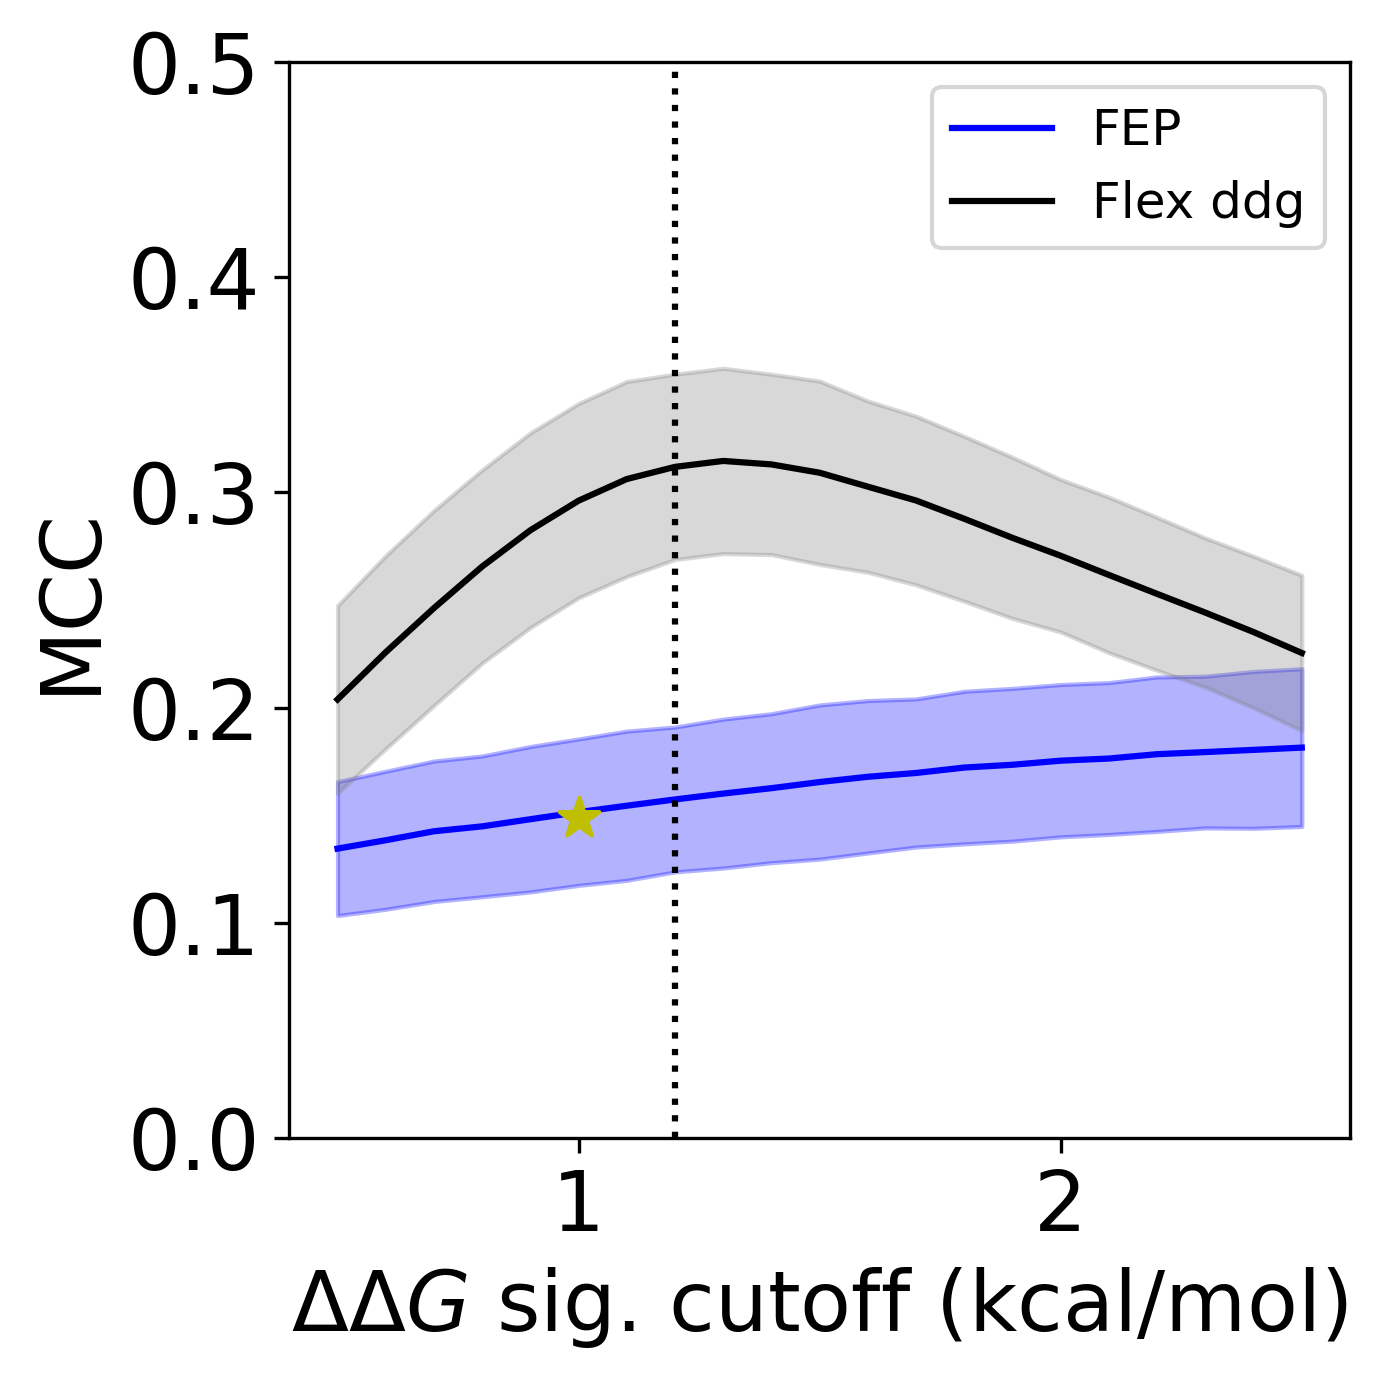

In [12]:
import tqdm
from scipy import stats
plt.rcParams.update({'font.size': 20})
mccs = [0.21299650509515503, 0.1228362957028676, 0.16497663150456532, 
        0.125923831013171, 0.09070675709615793,0.14873742097582718]
exp_cutoffs = np.arange(0.5,2.51,0.1)
vals = np.arange(0.5,2.51,0.1)
matrices = {'A8':{'EE':A8,  'R23':A8_curr_ros[A8.columns],  'R17':A8_ros_pub[A8.columns]},
            'A13':{'EE':A13,'R23':A13_curr_ros[A13.columns],'R17':A13_ros_pub[A13.columns]},
            'A18':{'EE':A18,'R23':A18_curr_ros[A18.columns],'R17':A18_ros_pub[A18.columns]}}

err_dic = {'A8':A8_var,'A13':A13_var,'A18':A18_var}

fig,ax = plt.subplots(figsize=(5,5),dpi=300)

exp_cutoff=1.2
A8_exp_class = trinary_classifier(A8_exp[A8.columns],cutoff=exp_cutoff)
A13_exp_class = trinary_classifier(A13_exp[A13.columns],cutoff=exp_cutoff)
A18_exp_class= trinary_classifier(A18_exp[A18.columns],cutoff=exp_cutoff)
exp_dic = {'A8':A8_exp_class,'A13':A13_exp_class,'A18':A18_exp_class}
flexddg_error = 0.96*(1/1.84)
FEP=[]
R23 = []
rosetta17 = []
EE_err=[]
R23_err = []
for key,val in matrices.items():
    mnp = key.split('_')[0]
    exp = exp_dic[mnp]
    erro = err_dic[mnp]
    for method, data in val.items():
        EE=False
        R=False
        arr = np.zeros(len(vals))
        err = np.zeros(len(vals))
        for k,cutoff in enumerate(vals):
            if 'R23' == method:
                R=True
                mean=[]
                for _ in range(1000):
                    noise_matrix = np.random.normal(loc=0, scale=flexddg_error, size=data.shape)
                    y=matthews_curve(data+noise_matrix,exp,cutoff=cutoff)
                    mean.append(y)
                arr[k]=np.mean(mean)
                err[k]=np.std(mean)
            elif 'R17' == method:
                pass
                #rosetta17.append(y)
            else:
                EE=True
                mean=[]
                for _ in range(1000):
                    noise_matrix = np.random.normal(loc=0, scale=1, size=data.shape)*erro.values
                    y=matthews_curve(data+noise_matrix,exp,cutoff=cutoff)
                    mean.append(y)
                arr[k]=np.mean(mean)
                err[k]=np.std(mean)
        if EE:
            FEP.append(arr)
            EE_err.append(err)
        elif R:
            R23.append(arr)
            R23_err.append(err)
       
FEP_mean = np.mean(FEP,axis=0)
rosetta23_mean = np.mean(R23,axis=0)
FEP_err = np.sqrt(np.sum([err**2 for err in EE_err],axis=0))
R23_err = np.sqrt(np.sum([err**2 for err in R23_err],axis=0))
ax.plot(vals,FEP_mean,label = 'FEP',c='b',zorder=0)
ax.plot(vals,rosetta23_mean,label = 'Flex ddg',c='k')
ax.fill_between(vals,FEP_mean-FEP_err,FEP_mean+FEP_err,color='b',alpha=0.3,zorder=0)
ax.fill_between(vals,rosetta23_mean-R23_err,rosetta23_mean+R23_err,color='gray',alpha=0.3)
ax.set_ylabel('MCC')
ax.set_xlabel('$\Delta \Delta G$ sig. cutoff (kcal/mol)')
FEP_max,FEP_val = np.max(FEP_mean).round(2),vals[np.argmax(FEP_mean)].round(2)
ros23_max,ros23_val = np.max(rosetta23_mean).round(2),vals[np.argmax(rosetta23_mean)].round(2)        
#ros17_max,ros17_val = np.max(rosetta17_mean).round(2),vals[np.argmax(rosetta17_mean)].round(2)                                         
ax.set_ylim(0,0.50)
ax.vlines(1.2,0,0.6,color='k',linestyle = ":")
ax.legend(list(ax.get_legend_handles_labels()[1]),loc='upper right',fontsize=12)
for f,val in enumerate(mccs):
    if f < len(mccs)-1:
       pass
    else:
        m='*'
        c='y'
        ax.scatter(1,val,marker=m,c=c,zorder=2,s=100) 
fig.tight_layout()

fig.savefig('Matthews_coeff_all.pdf',dpi=300,transparent=True)

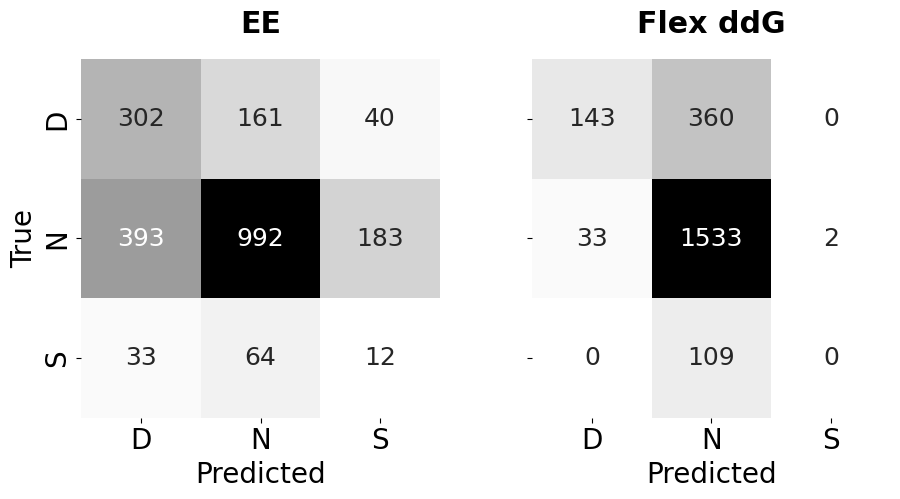

In [26]:
from matplotlib.colors import Normalize,LogNorm
plt.rcParams.update({'font.size': 20})

matrices = {'A8':{'EE':A8,  'R23':A8_curr_ros[A8.columns],  'R17':A8_ros_pub[A8.columns]},
            'A13':{'EE':A13,'R23':A13_curr_ros[A13.columns],'R17':A13_ros_pub[A13.columns]},
            'A18':{'EE':A18,'R23':A18_curr_ros[A18.columns],'R17':A18_ros_pub[A18.columns]}}
err_dic = {'A8':A8_var,'A13':A13_var,'A18':A18_var}
cutoff = 1.2
A8_exp_class = trinary_classifier(A8_exp[A8.columns],cutoff=cutoff)
A13_exp_class = trinary_classifier(A13_exp[A13.columns],cutoff=cutoff)
A18_exp_class= trinary_classifier(A18_exp[A18.columns],cutoff=cutoff)
exp_dic = {'A8':A8_exp_class,'A13':A13_exp_class,'A18':A18_exp_class}
FEP=[]
R23 = []
R17 = []
EE_err=[]
R23_err=[]
R17_err=[]
r23_random=[]
r17_random=[]
f_random=[]
for key,val in matrices.items():
    mnp = key.split('_')[0]
    erro = err_dic[mnp]
    exp = exp_dic[mnp]
    for method, data in val.items():
        if 'R23' == method:
            classified = trinary_classifier(data,cutoff=cutoff)
            R23.append(classified)
        elif 'R17' == method:
            classified = trinary_classifier(data,cutoff=cutoff)
            R17.append(classified)
        else:
            classified = trinary_classifier(data,cutoff=cutoff)
            FEP.append(classified)

l1 = [A8_exp_class.values.ravel(),A13_exp_class.values.ravel(),A18_exp_class.values.ravel()]
l2 = [i.values.ravel() for i in FEP]
l3 = [i.values.ravel() for i in R23]
l4 = [i.values.ravel() for i in R17]                       
cf1 = confusion_matrix(np.concatenate(l1),np.concatenate(l2),labels=['Destabilizing','Neutral','Stabilizing'])#,normalize='true')
cf2 = confusion_matrix(np.concatenate(l1),np.concatenate(l3),labels=['Destabilizing','Neutral','Stabilizing'])#,normalize='true')
cf3 = confusion_matrix(np.concatenate(l1),np.concatenate(l4),labels=['Destabilizing','Neutral','Stabilizing'])#,normalize='true')

fig,axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
plt.rcParams.update({'font.size': 18})
ax1,ax2 = axes.flat
from sklearn.metrics import ConfusionMatrixDisplay as CSD
labels= ['D','N','S']
#cbar_ax = fig.add_axes([.91, .14, .03, .71])
cmap='gist_yarg'
sns.heatmap(cf1,ax=ax1,cmap=cmap,annot=cf1,fmt='g',xticklabels=labels, 
                 yticklabels=labels,cbar=False,square=True)
sns.heatmap(cf2,ax=ax2,cmap=cmap,annot=cf2,fmt='g',xticklabels=labels, 
            yticklabels=labels,square=True,cbar=False)
#sns.heatmap(cf3,ax=ax3,cmap='coolwarm',annot=cf3,fmt='g',xticklabels=labels, 
#            yticklabels=labels,square=True,cbar=False)
ax1.set_title('EE',y=1.05,fontweight='bold')
ax2.set_title('Flex ddG',y=1.05,fontweight='bold')
#ax3.set_title('Chev. 2017')
ax1.set_ylabel('True')

#cbar = ax1.collections[0].colorbar
#cbar.set_label('Count',rotation=270,labelpad=20)
#cbar.ax.set_position([0.99, 0.1, 0.05, 0.8])
for ax in axes.flat:
    ax.set_xlabel('Predicted')
fig.tight_layout()
plt.savefig('Confusion_matrix_SI.pdf',dpi=300,bbox_inches='tight',transparent=True)

In [215]:
print('Destabilizing')
print('A8:',len([i for i in A8_exp[A8.columns].values.flatten() if i >=1.2]))
print('A13:',len([i for i in A13_exp[A13.columns].values.flatten() if i >=1.2]))
print('A18:',len([i for i in A18_exp[A18.columns].values.flatten() if i >=1.2]))
print('Stabilizing')
print('A8:',len([i for i in A8_exp[A8.columns].values.flatten() if i <=-1.2]))
print('A13:',len([i for i in A13_exp[A13.columns].values.flatten() if i <=-1.2]))
print('A18:',len([i for i in A18_exp[A18.columns].values.flatten() if i <=-1.2]))

Destabilizing
A8: 186
A13: 181
A18: 136
Stabilizing
A8: 0
A13: 32
A18: 77


Destabilizing
Stabilizing
Destabilizing
Stabilizing


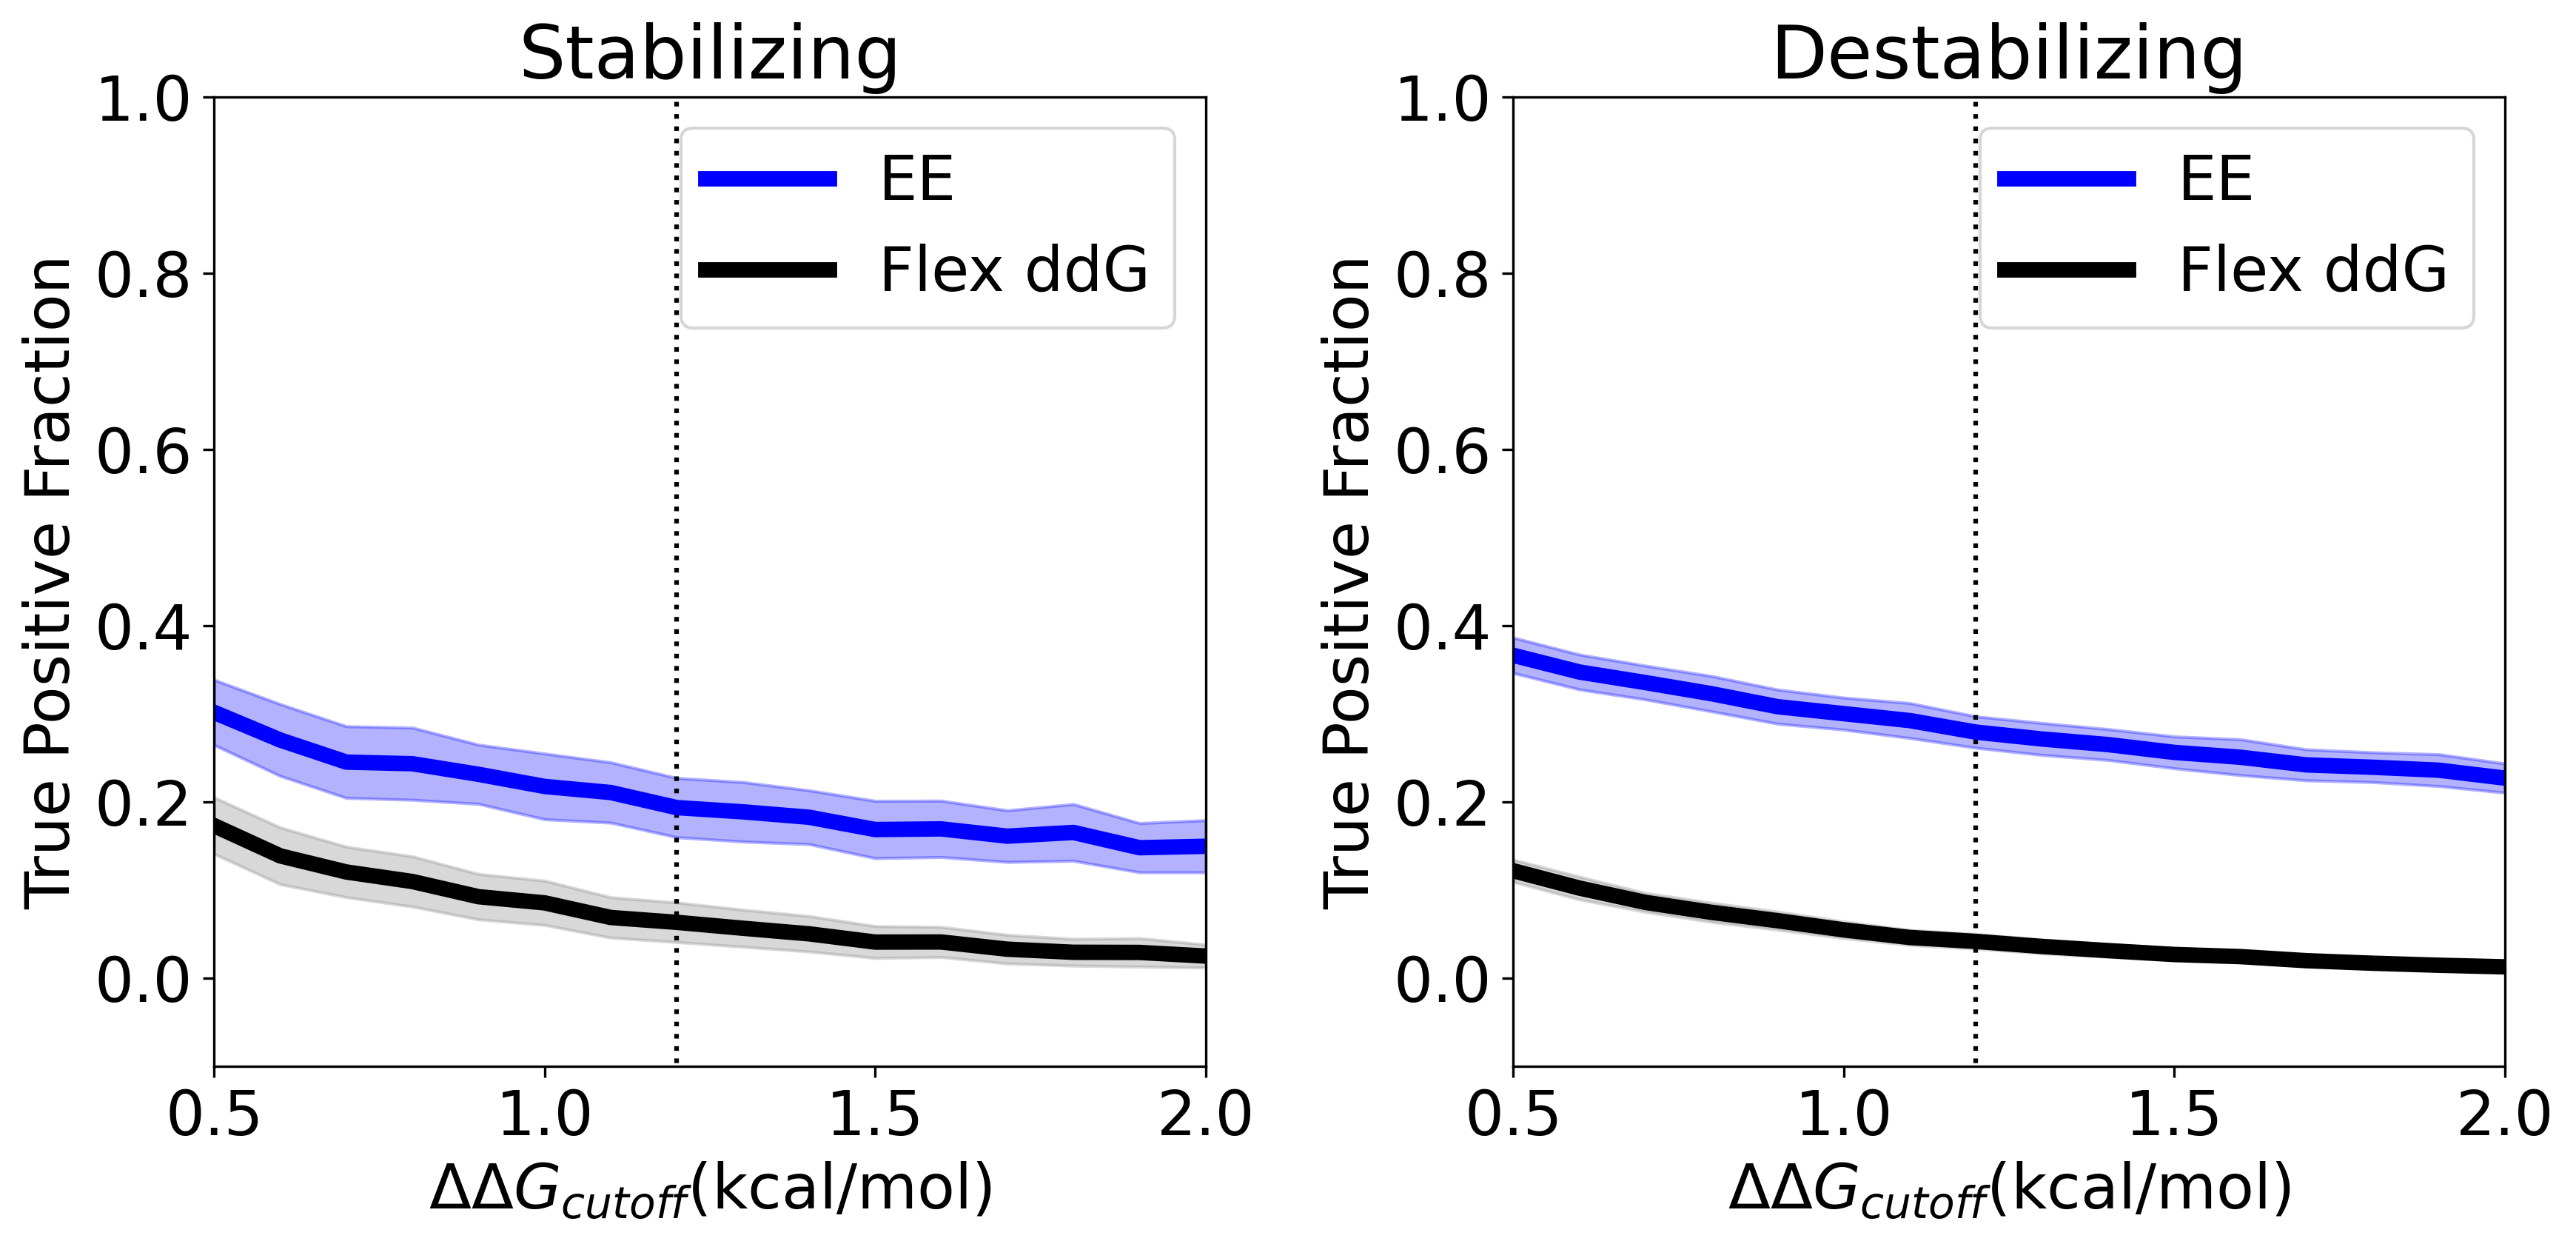

In [4]:
cutoffs=np.arange(0.5,2.1,0.1)
plt.rcParams.update({'font.size': 20})
err_dic = {'A8':A8_var,'A13':A13_var,'A18':A18_var}
flexddg_error = 0.96*(1/1.84)


fig,axes = plt.subplots(1,2,figsize=(12,6),dpi=300)
ax1,ax2=axes.flat

print('Destabilizing')

A8_dest = len([i for i in A8_exp[A8.columns].values.flatten() if i >=1.2])
A13_dest = len([i for i in A13_exp[A13.columns].values.flatten() if i >=1.2])
A18_dest = len([i for i in A18_exp[A18.columns].values.flatten() if i >=1.2])
A8_idx =  [i for i,val in enumerate(A8_exp[A8.columns].values.flatten()) if val >=1.2]
A13_idx = [i for i,val in enumerate(A13_exp[A13.columns].values.flatten()) if val >=1.2]
A18_idx = [i for i,val in enumerate(A18_exp[A18.columns].values.flatten()) if val >=1.2]

v1 = []
v1_err = []
for c in cutoffs:
    A8_dest_EE = []
    for _ in range(100):
        A8_values = A8.values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A8_values.shape) * err_dic['A8'].values.flatten()
        A8_values *= noise_matrix
        A8_dest_EE.append(len([i for i in A8_values[A8_idx] if i >=c]))
    A8_dest_EE_err = np.std( A8_dest_EE)
    A8_dest_EE = np.mean(A8_dest_EE)
    
    A13_dest_EE = []
    for _ in range(100):
        A13_values = A13.values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A13_values.shape) * err_dic['A13'].values.flatten()
        A13_values *= noise_matrix
        A13_dest_EE.append(len([i for i in A13_values[A13_idx] if i >=c]))
    A13_dest_EE_err = np.std(A13_dest_EE)
    A13_dest_EE = np.mean( A13_dest_EE)
    
    A18_dest_EE = []
    for _ in range(100):
        A18_values = A18.values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A18_values.shape) * err_dic['A18'].values.flatten()
        A18_values *= noise_matrix
        A18_dest_EE.append(len([i for i in A18_values[A18_idx] if i >=c]))
    A18_dest_EE_err = np.std(A18_dest_EE)
    A18_dest_EE = np.mean(A18_dest_EE)
    
    v1.append(sum([A8_dest_EE,A13_dest_EE,A18_dest_EE]))
    v1_err.append(np.sqrt(np.sum([A8_dest_EE_err**2,A13_dest_EE_err**2,A18_dest_EE_err**2])))
    
EE_dest = np.array(v1)/sum([A8_dest,A13_dest,A18_dest])    
EE_dest_err = np.array(v1_err)/sum([A8_dest,A13_dest,A18_dest]) 

ax2.plot(cutoffs,EE_dest,label='EE',linewidth=5,c='b')
ax2.fill_between(cutoffs,EE_dest-EE_dest_err,EE_dest+EE_dest_err,color='b',alpha=0.3)

print('Stabilizing')
A8_stab = len([i for i in A8_exp[A8.columns].values.flatten() if i <=-1.2])
A13_stab = len([i for i in A13_exp[A13.columns].values.flatten() if i <=-1.2])
A18_stab = len([i for i in A18_exp[A18.columns].values.flatten() if i <=-1.2])
A8_idx =  [i for i,val in enumerate(A8_exp[A8.columns].values.flatten()) if val <=-1.2]
A13_idx = [i for i,val in enumerate(A13_exp[A13.columns].values.flatten()) if val <=-1.2]
A18_idx = [i for i,val in enumerate(A18_exp[A18.columns].values.flatten()) if val <=-1.2]
v2=[]
v2_err=[]
for c in cutoffs:
    A8_stab_EE = []
    for _ in range(100):
        A8_values = A8.values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A8_values.shape) * err_dic['A8'].values.flatten()
        A8_values *= noise_matrix
        A8_stab_EE.append(len([i for i in A8_values[A8_idx] if i <=-c]))
    A8_stab_EE_err = np.std( A8_stab_EE)
    A8_stab_EE = np.mean(A8_stab_EE)
    
    A13_stab_EE = []
    for _ in range(100):
        A13_values = A13.values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A13_values.shape) * err_dic['A13'].values.flatten()
        A13_values *= noise_matrix
        A13_stab_EE.append(len([i for i in A13_values[A13_idx] if i <=-c]))
    A13_stab_EE_err = np.std(A13_stab_EE)
    A13_stab_EE = np.mean( A13_stab_EE)
    
    A18_stab_EE = []
    for _ in range(100):
        A18_values = A18.values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A18_values.shape) * err_dic['A18'].values.flatten()
        A18_values *= noise_matrix
        A18_stab_EE.append(len([i for i in A18_values[A18_idx] if i <=-c]))
    A18_stab_EE_err = np.std(A18_stab_EE)
    A18_stab_EE = np.mean(A18_stab_EE)
    
    v2.append(sum([A8_stab_EE,A13_stab_EE,A18_stab_EE]))
    v2_err.append(np.sqrt(np.sum([A8_stab_EE_err**2,A13_stab_EE_err**2,A18_stab_EE_err**2])))
    
EE_stab = np.array(v2)/sum([A8_stab,A13_stab,A18_stab])    
EE_stab_err = np.array(v2_err)/sum([A8_stab,A13_stab,A18_stab]) 

ax1.plot(cutoffs,EE_stab,label='EE',linewidth=5,c='b')
ax1.fill_between(cutoffs,EE_stab-EE_stab_err,EE_stab+EE_stab_err,color='b',alpha=0.3)

#############################################################################################################################################

print('Destabilizing')

A8_dest = len([i for i in A8_exp[A8.columns].values.flatten() if i >=1.2])
A13_dest = len([i for i in A13_exp[A13.columns].values.flatten() if i >=1.2])
A18_dest = len([i for i in A18_exp[A18.columns].values.flatten() if i >=1.2])
A8_idx =  [i for i,val in enumerate(A8_exp[A8.columns].values.flatten()) if val >=1.2]
A13_idx = [i for i,val in enumerate(A13_exp[A13.columns].values.flatten()) if val >=1.2]
A18_idx = [i for i,val in enumerate(A18_exp[A18.columns].values.flatten()) if val >=1.2]

v1 = []
v1_err = []
for c in cutoffs:
    A8_dest_EE = []
    for _ in range(100):
        A8_values = A8_curr_ros[A8.columns].values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A8_values.shape) * flexddg_error
        A8_values *= noise_matrix
        A8_dest_EE.append(len([i for i in A8_values[A8_idx] if i >=c]))
    A8_dest_EE_err = np.std( A8_dest_EE)
    A8_dest_EE = np.mean(A8_dest_EE)
    
    A13_dest_EE = []
    for _ in range(100):
        A13_values = A13_curr_ros[A13.columns].values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A13_values.shape) * flexddg_error
        A13_values *= noise_matrix
        A13_dest_EE.append(len([i for i in A13_values[A13_idx] if i >=c]))
    A13_dest_EE_err = np.std(A13_dest_EE)
    A13_dest_EE = np.mean( A13_dest_EE)
    
    A18_dest_EE = []
    for _ in range(100):
        A18_values = A18_curr_ros[A18.columns].values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A18_values.shape) * flexddg_error
        A18_values *= noise_matrix
        A18_dest_EE.append(len([i for i in A18_values[A18_idx] if i >=c]))
    A18_dest_EE_err = np.std(A18_dest_EE)
    A18_dest_EE = np.mean(A18_dest_EE)
    
    v1.append(sum([A8_dest_EE,A13_dest_EE,A18_dest_EE]))
    v1_err.append(np.sqrt(np.sum([A8_dest_EE_err**2,A13_dest_EE_err**2,A18_dest_EE_err**2])))
    
EE_dest = np.array(v1)/sum([A8_dest,A13_dest,A18_dest])    
EE_dest_err = np.array(v1_err)/sum([A8_dest,A13_dest,A18_dest]) 

ax2.plot(cutoffs,EE_dest,label='Flex ddG',linewidth=5,c='k')
"""
# Uncomment to plot Supplementary Fig.3
destab_22 = [0.85,0.73,0.86,0.76,0.69,0.77]
for f,val in enumerate(destab_22):
    if f < len(destab_22)-1:
        pass # ax1.scatter(1,val,zorder=2,s=100) 
    else:
        '''
        # Uncomment to plot Supplementary Fig.3
        m='*'
        c='y'
        ax2.scatter(1,val,marker=m,c=c,zorder=2,s=100) 
"""
ax2.fill_between(cutoffs,EE_dest-EE_dest_err,EE_dest+EE_dest_err,color='grey',alpha=0.3)

print('Stabilizing')
A8_stab = len([i for i in A8_exp[A8.columns].values.flatten() if i <=-1.2])
A13_stab = len([i for i in A13_exp[A13.columns].values.flatten() if i <=-1.2])
A18_stab = len([i for i in A18_exp[A18.columns].values.flatten() if i <=-1.2])
A8_idx =  [i for i,val in enumerate(A8_exp[A8.columns].values.flatten()) if val <=-1.2]
A13_idx = [i for i,val in enumerate(A13_exp[A13.columns].values.flatten()) if val <=-1.2]
A18_idx = [i for i,val in enumerate(A18_exp[A18.columns].values.flatten()) if val <=-1.2]
v2=[]
v2_err=[]
for c in cutoffs:
    A8_stab_EE = []
    for _ in range(100):
        A8_values = A8.values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A8_values.shape) * flexddg_error
        A8_values *= noise_matrix
        A8_stab_EE.append(len([i for i in A8_values[A8_idx] if i <=-c]))
    A8_stab_EE_err = np.std( A8_stab_EE)
    A8_stab_EE = np.mean(A8_stab_EE)
    
    A13_stab_EE = []
    for _ in range(100):
        A13_values = A13.values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A13_values.shape) * flexddg_error
        A13_values *= noise_matrix
        A13_stab_EE.append(len([i for i in A13_values[A13_idx] if i <=-c]))
    A13_stab_EE_err = np.std(A13_stab_EE)
    A13_stab_EE = np.mean( A13_stab_EE)
    
    A18_stab_EE = []
    for _ in range(100):
        A18_values = A18.values.flatten()
        noise_matrix = np.random.normal(loc=0, scale=1, size=A18_values.shape) * flexddg_error
        A18_values *= noise_matrix
        A18_stab_EE.append(len([i for i in A18_values[A18_idx] if i <=-c]))
    A18_stab_EE_err = np.std(A18_stab_EE)
    A18_stab_EE = np.mean(A18_stab_EE)
    
    v2.append(sum([A8_stab_EE,A13_stab_EE,A18_stab_EE]))
    v2_err.append(np.sqrt(np.sum([A8_stab_EE_err**2,A13_stab_EE_err**2,A18_stab_EE_err**2])))
    
EE_stab = np.array(v2)/sum([A8_stab,A13_stab,A18_stab])    
EE_stab_err = np.array(v2_err)/sum([A8_stab,A13_stab,A18_stab]) 

ax1.plot(cutoffs,EE_stab,label='Flex ddG',linewidth=5,c='k')
"""
# Uncomment to plot Supplementary Fig.3
stab_22 = [0.15,0.15,0.14,0.08,0.11,0.13]
for f,val in enumerate(stab_22):
    if f < len(stab_22)-1:
        pass
    else:
        m='*'
        c='y'
        ax1.scatter(1,val,marker=m,c=c,zorder=2,s=100)
"""
ax1.fill_between(cutoffs,EE_stab-EE_stab_err,EE_stab+EE_stab_err,color='grey',alpha=0.3)


ax1.vlines(1.2,-0.5,1,color='k',linestyle=':')
ax2.vlines(1.2,-0.5,1,color='k',linestyle=':')
ax1.set_title('Stabilizing')
ax2.set_title('Destabilizing')
ax1.set_ylim(-0.1,1)
ax2.set_ylim(-0.1,1)
ax1.set_xlim(0.5,2)
ax2.set_xlim(0.5,2)
for ax in axes.flat:
    ax.set_xlabel('$\Delta \Delta G_{cutoff}$(kcal/mol)')
    ax.set_ylabel('True Positive Fraction')
    ax.legend(loc='upper right')

fig.tight_layout()
fig.savefig('frac_correct_no_stars.pdf',dpi=300,transparent=True)

In [4]:
from scipy.stats import ttest_ind
matrices = {'A8':{'EE':A8,  'R23':A8_curr_ros[A8.columns],  'R17':A8_ros_pub[A8.columns]},
            'A13':{'EE':A13,'R23':A13_curr_ros[A13.columns],'R17':A13_ros_pub[A13.columns]},
            'A18':{'EE':A18,'R23':A18_curr_ros[A18.columns],'R17':A18_ros_pub[A18.columns]}}
err_dic = {'A8':A8_var,'A13':A13_var,'A18':A18_var}
cutoff=1.2

A8_exp_class = trinary_classifier(A8_exp[A8.columns],cutoff=cutoff)
A13_exp_class = trinary_classifier(A13_exp[A13.columns],cutoff=cutoff)
A18_exp_class= trinary_classifier(A18_exp[A18.columns],cutoff=cutoff)
exp_dic = {'A8':A8_exp_class,'A13':A13_exp_class,'A18':A18_exp_class}
FEP=[]
R23 = []
R17 = []
EE_err=[]
R23_err=[]
R17_err=[]
r23_random=[]
r17_random=[]
f_random=[]
for key,val in matrices.items():
    mnp = key.split('_')[0]
    erro = err_dic[mnp]
    exp = exp_dic[mnp]
    for method, data in val.items():
        if 'R23' == method:
            #classified = matthews_curve(data,exp,cutoff=cutoff)
            #R23.append(classified)
            for i in range(3333):
                c_random = random_curve(data,exp,cutoff=cutoff)
                r23_random.append(c_random)
        elif 'R17' == method:
            #classified = matthews_curve(data,exp,cutoff=cutoff)
            #R17.append(classified)
            for i in range(3333):
                c_random = random_curve(data,exp,cutoff=cutoff)
                r17_random.append(c_random)
        else:
            for i in range(3333):
                c_random = random_curve(data,exp,cutoff=cutoff)
                f_random.append(c_random)
                
matrices = {'A8':{'EE':A8[A8_exp[A8.columns].abs()>=1.2],
                  'R23':A8_curr_ros[A8.columns][A8_exp[A8.columns].abs()>=1.2],
                  'R17':A8_ros_pub[A8.columns][A8_exp[A8.columns].abs()>=1.2]},
            'A13':{'EE':A13[A13_exp[A13.columns].abs()>=1.2],
                   'R23':A13_curr_ros[A13.columns][A13_exp[A13.columns].abs()>=1.2],
                   'R17':A13_ros_pub[A13.columns][A13_exp[A13.columns].abs()>=1.2]},
            'A18':{'EE':A18[A18_exp[A18.columns].abs()>=1.2],
                   'R23':A18_curr_ros[A18.columns][A18_exp[A18.columns].abs()>=1.2],
                   'R17':A18_ros_pub[A18.columns][A18_exp[A18.columns].abs()>=1.2]}
           }
err_dic = {'A8':A8_var,'A13':A13_var,'A18':A18_var}
"""
cutoff=1.2

A8_exp_class = trinary_classifier(A8_exp[A8.columns][A8_exp[A8.columns].abs()>=1.2],cutoff=cutoff)
A13_exp_class = trinary_classifier(A13_exp[A13.columns][A13_exp[A13.columns].abs()>=1.2],cutoff=cutoff)
A18_exp_class= trinary_classifier(A18_exp[A18.columns][A18_exp[A18.columns].abs()>=1.2],cutoff=cutoff)
exp_dic = {'A8':A8_exp_class,'A13':A13_exp_class,'A18':A18_exp_class}
FEP_12=[]
R23_12 = []
R17_12 = []
EE_err_12=[]
R23_err_12=[]
R17_err_12=[]
r23_random_12=[]
r17_random_12=[]
f_random_12=[]
for key,val in matrices.items():
    mnp = key.split('_')[0]
    erro = err_dic[mnp]
    exp = exp_dic[mnp]
    for method, data in val.items():
        if 'R23' == method:
            classified = matthews_curve(data,exp,cutoff=cutoff)
            R23_12.append(classified)
            for i in range(3333):
                c_random = random_curve(data,exp,cutoff=cutoff)
                r23_random_12.append(c_random)
        elif 'R17' == method:
            classified = matthews_curve(data,exp,cutoff=cutoff)
            R17_12.append(classified)
            for i in range(3333):
                c_random = random_curve(data,exp,cutoff=cutoff)
                r17_random_12.append(c_random)
        else:
            classified = matthews_curve(data,exp,cutoff=cutoff)
            err_p = matthews_curve(data+erro.values,exp,cutoff=cutoff)
            err_m = matthews_curve(data-erro.values,exp,cutoff=cutoff)
            EE_err_12.append(np.std([err_p,err_m]))
            FEP_12.append(classified)
            for i in range(3333):
                c_random = random_curve(data,exp,cutoff=cutoff)
                f_random_12.append(c_random)
"""

"\ncutoff=1.2\n\nA8_exp_class = trinary_classifier(A8_exp[A8.columns][A8_exp[A8.columns].abs()>=1.2],cutoff=cutoff)\nA13_exp_class = trinary_classifier(A13_exp[A13.columns][A13_exp[A13.columns].abs()>=1.2],cutoff=cutoff)\nA18_exp_class= trinary_classifier(A18_exp[A18.columns][A18_exp[A18.columns].abs()>=1.2],cutoff=cutoff)\nexp_dic = {'A8':A8_exp_class,'A13':A13_exp_class,'A18':A18_exp_class}\nFEP_12=[]\nR23_12 = []\nR17_12 = []\nEE_err_12=[]\nR23_err_12=[]\nR17_err_12=[]\nr23_random_12=[]\nr17_random_12=[]\nf_random_12=[]\nfor key,val in matrices.items():\n    mnp = key.split('_')[0]\n    erro = err_dic[mnp]\n    exp = exp_dic[mnp]\n    for method, data in val.items():\n        if 'R23' == method:\n            classified = matthews_curve(data,exp,cutoff=cutoff)\n            R23_12.append(classified)\n            for i in range(3333):\n                c_random = random_curve(data,exp,cutoff=cutoff)\n                r23_random_12.append(c_random)\n        elif 'R17' == method:\n        

0.00040004000400040005 <10E-5
EE 0.15697607164020133 Flex ddG 0.3125568980810962
EE_unc 0.035004341430317866 Flex ddg_unc 0.04545695490697447


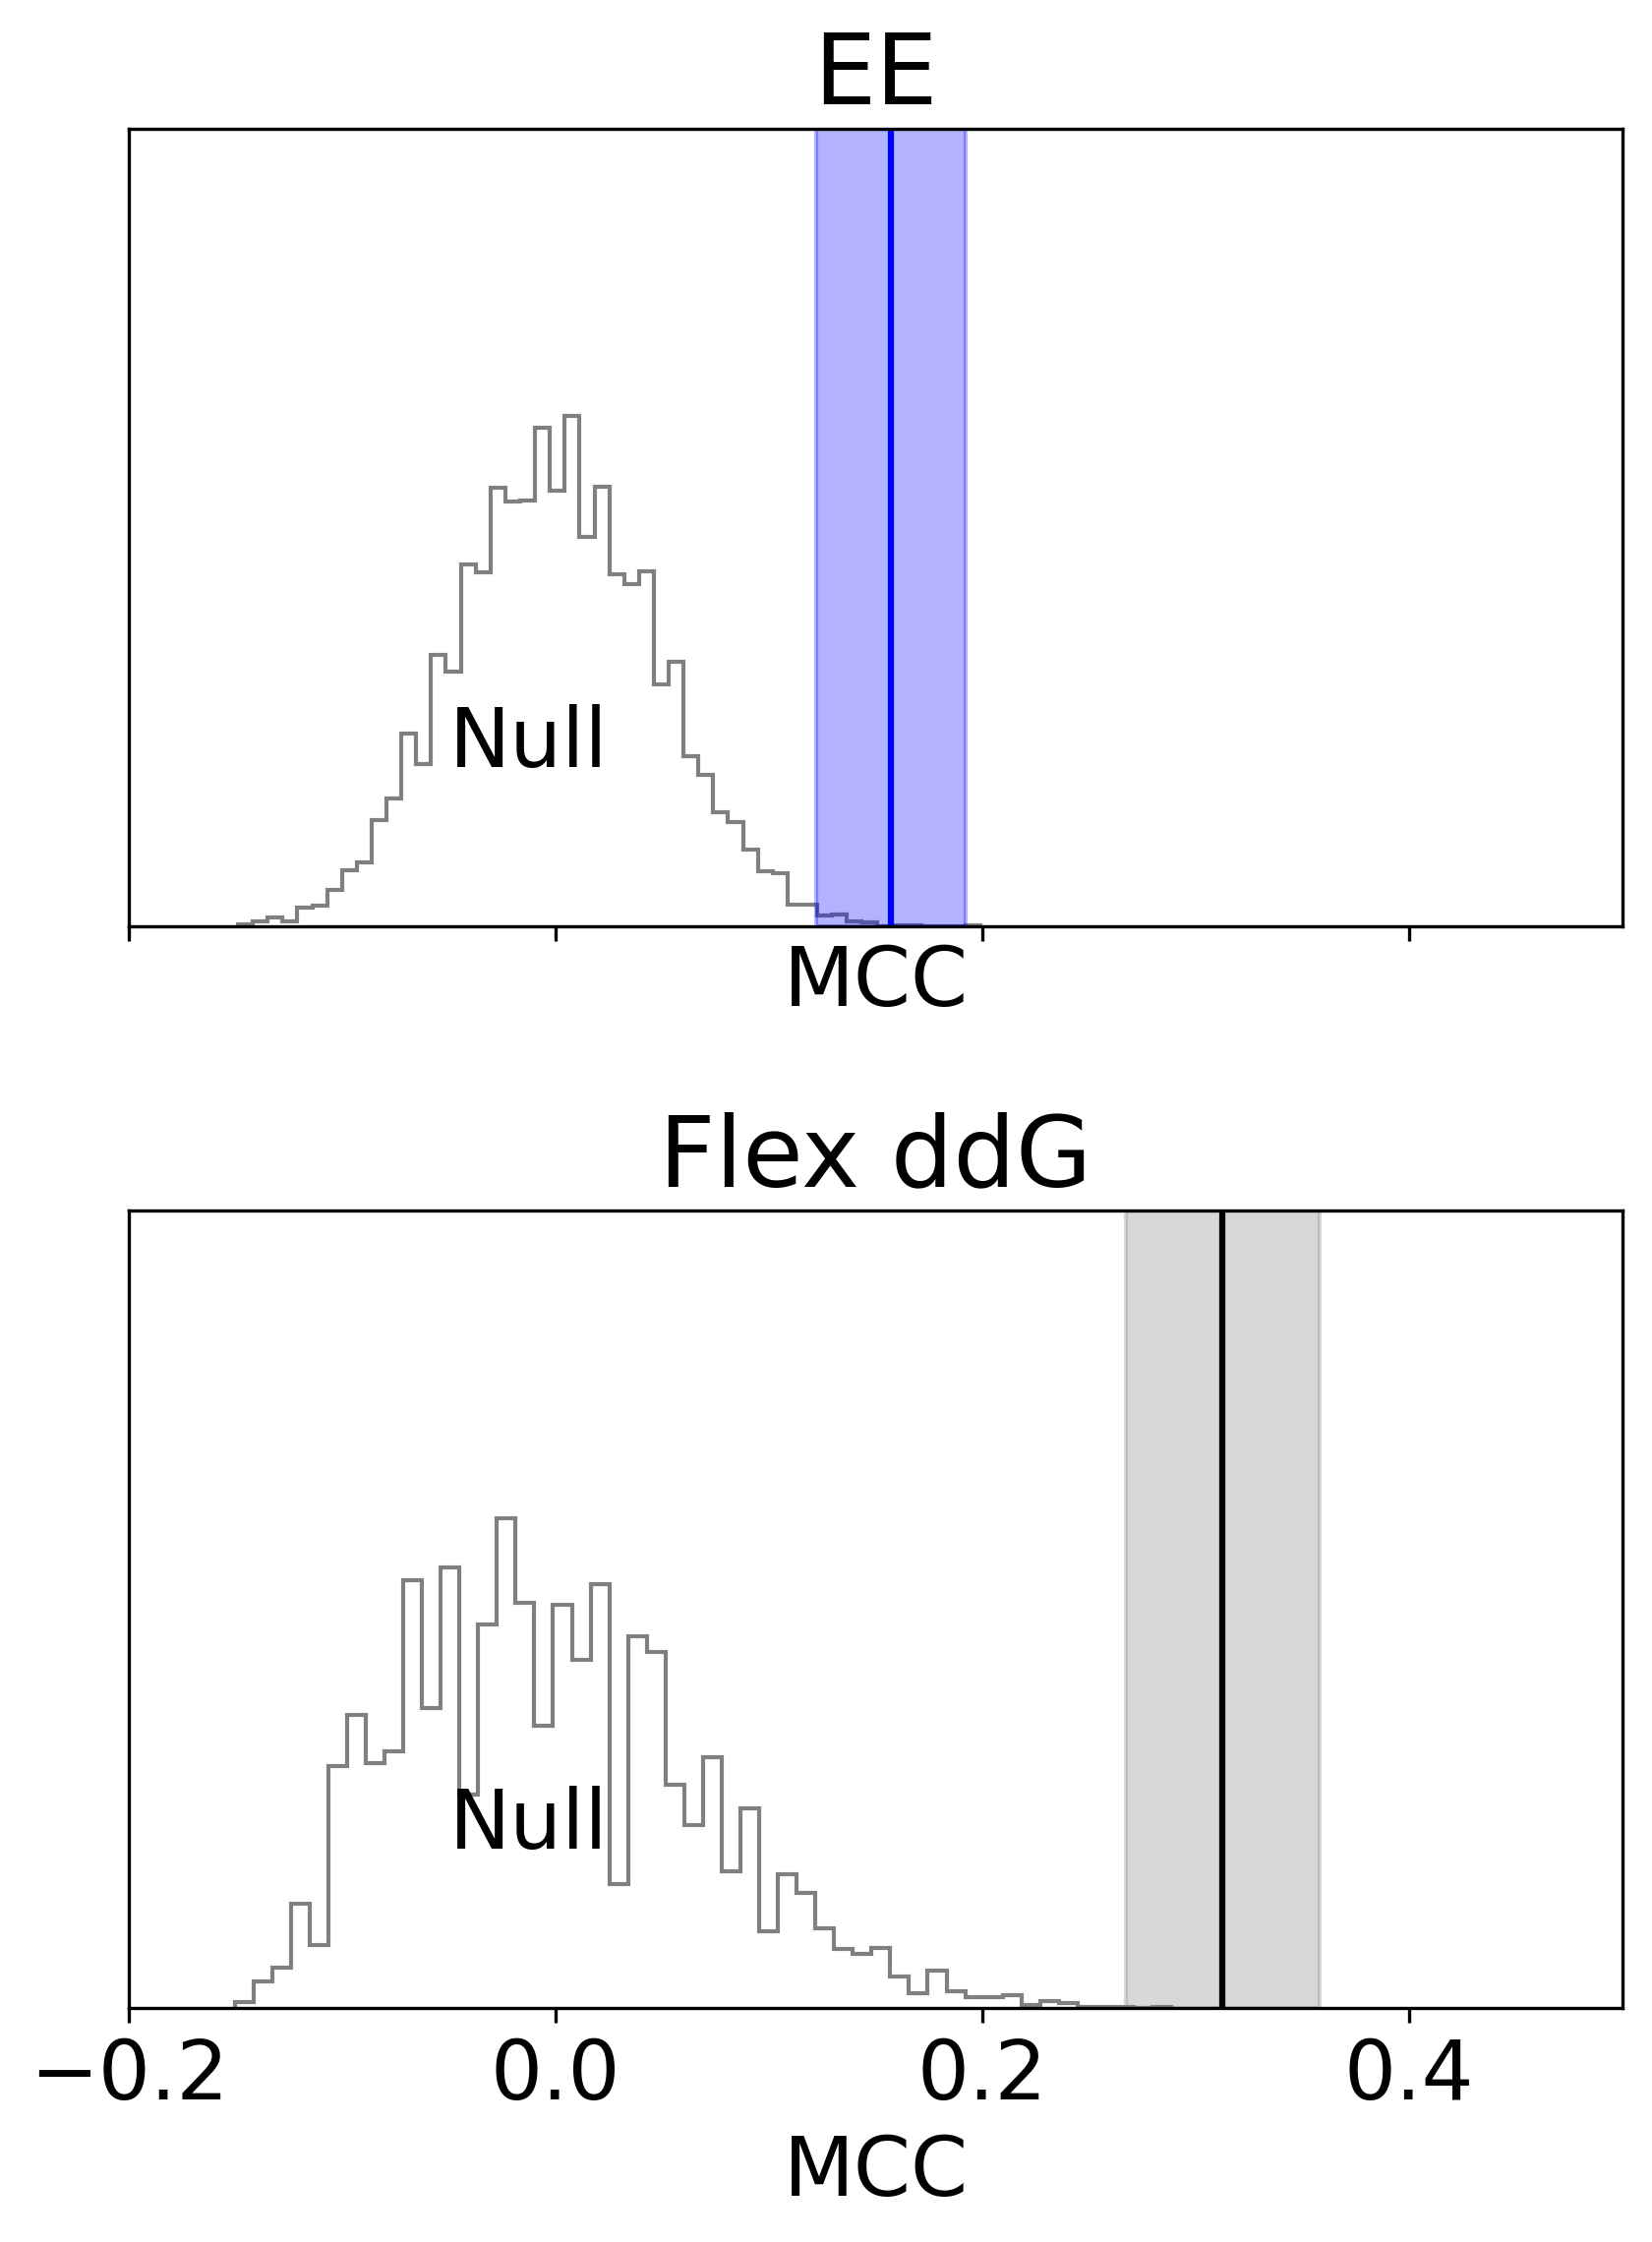

In [17]:
fig,axes = plt.subplots(2,1,figsize=(6,8),sharey=True,sharex=True,dpi=300)
vals = np.arange(0.5,2.51,0.1)

plt.rcParams.update({'font.size': 20})
EE_means = np.load('MCC_mean_EE.npy')
EE_mean = EE_means[np.argwhere(np.around(vals,1)==1.2)][0][0]
EE_uncs = np.load('MCC_err_EE.npy')
EE_unc = EE_uncs[np.argwhere(np.around(vals,1)==1.2)][0][0]

R23_means = np.load('MCC_mean_fddg.npy')
R23_uncs = np.load('MCC_err_fddg.npy')
R23_mean = R23_means[np.argwhere(np.around(vals,1)==1.2)][0][0]
R23_unc = R23_uncs[np.argwhere(np.around(vals,1)==1.2)][0][0]



ax1,ax2 = axes.flat
p_f = len(np.where(f_random >= EE_mean)[0])/len(f_random)
p_r23 = np.around(len(np.where(r23_random >= R23_mean)[0])/len(r23_random),2)
#p_r17 = np.around(len(np.where(r17_random >= np.mean(R17))[0])/len(r17_random),2)
#p_f_12 = len(np.where(f_random_12 >= np.mean(FEP_12))[0])/len(f_random_12)
#p_r23_12 = np.around(len(np.where(r23_random_12 >= np.mean(R23_12))[0])/len(r23_random_12),2)
#p_r17_12 = np.around(len(np.where(r17_random_12 >= np.mean(R17_12))[0])/len(r17_random_12),2)
if p_f == 0.0:
    p_f = "<10E-5"
if p_r23 == 0.0:
    p_r23 = "<10E-5"

print(p_f,p_r23)
"""
if p_f_12 == 0.0:
    p_f_12 = '$<10^{-5}$'
if p_r23_12 == 0.0:
    p_r23_12 = '$<10^{-5}$'
if p_r17_12 == 0.0:
    p_r17_12 = '$<10^{-5}$'
"""
ax1.hist(f_random,weights=np.ones(len(f_random))/len(f_random),color='gray',bins=50,histtype=u'step',label='Null')
ax2.hist(r23_random,weights=np.ones(len(r23_random))/len(r23_random),color='gray',bins=50,histtype=u'step')
#ax3.hist(r17_random,weights=np.ones(len(r17_random))/len(r17_random),color='gray',bins=50,histtype=u'step')
#ax4.hist(f_random_12,weights=np.ones(len(f_random_12))/len(f_random_12),color='gray',bins=50,histtype=u'step')
#ax5.hist(r23_random_12,weights=np.ones(len(r23_random_12))/len(r23_random_12),color='gray',bins=50,histtype=u'step')
#ax6.hist(r17_random_12,weights=np.ones(len(r17_random_12))/len(r17_random_12),color='gray',bins=50,histtype=u'step')


ax1.vlines(EE_mean,0,0.2,color='b',label='FEP')
ax2.vlines(R23_mean,0,0.2,color='k',label='Flex ddg')
print('EE',EE_mean,'Flex ddG',R23_mean)
#ax3.vlines(np.mean(R17),0,0.2,color='r',label='Chev. 2017')
#ax4.vlines(np.mean(FEP_12),0,0.2,color='k')
#ax5.vlines(np.mean(R23_12),0,0.2,color='b')
#ax6.vlines(np.mean(R17_12),0,0.2,color='r')
#fig.legend(loc = 'lower center',ncol=4,bbox_to_anchor=(0.5,-0.1))

ax1.axvspan(EE_mean-EE_unc,
            EE_mean+EE_unc, alpha=0.3, color='b')
print('EE_unc',EE_unc,'Flex ddg_unc',R23_unc)
ax2.axvspan(R23_mean-R23_unc,
            R23_mean+R23_unc, alpha=0.3, color='gray')
#ax3.axvspan(np.mean(R17)-np.std(R17),np.mean(R17)+np.std(R17), alpha=0.3, color='orange')
#ax4.axvspan(np.mean(FEP_12)-np.sqrt(sum([i**2 for i in EE_err_12])),
            #np.mean(FEP_12)+np.sqrt(sum([i**2 for i in EE_err_12])), alpha=0.3, color='b')
#ax5.axvspan(np.mean(R23_12)-np.std(R23_12),np.mean(R23_12)+np.std(R23_12), alpha=0.3, color='gray')
#ax6.axvspan(np.mean(R17_12)-np.std(R17_12),np.mean(R17_12)+np.std(R17_12), alpha=0.3, color='orange')

#ax1.text(-0.1,0.175,f'p-value {p_f}')
#ax2.text(-0.1,0.175,f'p-value {p_r23}')
#ax3.text(-0.1,0.175,f'p-value {p_r17}')
#ax4.text(-0.1,0.175,f'p-value {p_f_12}')
#ax5.text(-0.1,0.175,f'p-value {p_r23_12}')
#ax6.text(-0.1,0.175,f'p-value {p_r17_12}')
ax1.set_title('EE')
ax2.set_title('Flex ddG')

for i,ax in enumerate(axes.flat):
    ax.set_xlabel('MCC')
    ax.set_yticks([])
    ax.text(-0.05,0.02,'Null')
    ax.set_ylim(0,0.1)
    if i < 3:
        ax.set_xlim(-0.2,0.5)
    else:
        ax.set_xticks(np.arange(0,0.8,0.25))
        ax.set_xlim(-0.2,0.9)
    """
    if i == 0:
        prob='Probability'
        ax.set_ylabel(f'{prob}')
    elif i==3: 
        prob='Sig. Effect\nProbability'
        ax.set_ylabel(f'{prob}')
    """
fig.tight_layout()
fig.savefig('MCC_and_null_figure8.pdf',dpi=300,bbox_inches='tight',transparent=True)